<div class="alert alert-info">

**Important Notes**
    
- Make sure that you are running `statsmodels 0.12.2` when training your ARIMA models.
 
</div>

# Problem 2. Time Series: Forecasting the Average Monthly Temperature of Metro Manila (40 pts)

In this problem, you will apply ARIMA to forecast the time-series data provided by the Philippine Atmospheric, Geophysical and Astronomical Services Administration (PAG-ASA). PAGASA is the Philippine national institution dedicated to provide flood and typhoon warnings, public weather forecasts and advisories, meteorological, astronomical, climatological, and other specialized information and services primarily for the protection of life and property and in support of economic, productivity and sustainable development. The government agency was created on December 8, 1972 by virtue of Presidential Decree No. 78 reorganizing the Philippine Weather Bureau into PAGASA.*

Read and execute carefully the instructions provided. 


*http://www.pagasa.dost.gov.ph/


## Context


You've recently been hired by PAG-ASA as their new data science consultant. Congratulations!

Your task is to create a forecasting model that can predict the **average monthly temperature** for Metro Manila.

Specifically, your goal is to create a <u>6-month ahead</u> forecaster.

<img src="pag-asa_logo.png" alt="drawing" width="200">


## Tasks:

0. Load the data from `manila_monthly_temp.csv`. (based on [`GSOD`](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516))


1. Plot the `avg` series and its ACF plot. [5 pts]  
    
    
2. Hold out all the observations in 2020. These will be used for the test sets below.
    
    
3. Implement a pipeline that finds the optimal ARIMA parameters $(p,d,q)$ using the training set. [10 pts]

Fill-up the table below:

| Forecasting Method | Avg. Test MAE | Avg. Test RMSE | Avg. Test MAPE |
| :---: | :---: | :---: | :---: |
| Naive / Persistence* | X | X | X |
| Seasonal Naive | X | X | X |
| ARIMA(?,?,?) | X | X | X |

*In weather and climate modeling, the naive method for forecasting is usually referred to as the [`persistence method`](https://en.wikipedia.org/wiki/Weather_forecasting#Persistence).

Metrics:

- [`Mean Absolute Error (MAE)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)
- [`Root Mean Squared Error (RMSE)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
- [`Mean Absolute Percentage Error (MAPE)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html)

To caculate the average test errors, use time series cross-validation (TSCV) as defined by Hyndman and Athanasopoulos.

You have complete freedom in designing your pipeline, everything from pre-processing techniques to grid-search CV.

Your only objective is to train an ARIMA model that can outperform the two naive baseline methods in terms of the defined error metrics.

4. Plot the final test set (last 6 months of 2020) along with your ARIMA, Naive, and S.Naive forecasts. Make sure your plot is properly labeled. [5 pts]

5. Write a report and interpret your results. Your goal is to demonstrate to the heads of PAG-ASA that there is merit to data science and using machine learning as a tool to help them in their forecasting. [20 pts]

<div class='alert alert-success'>

**Some guide questions**

- How would you explain these results to your stakeholders? A lot of people are actually not familiar with time series analysis!
- What are the limitations of this sort of analysis?
- Some members of the PAG-ASA team that may not have seen MAE/RMSE/MAPE before. Based on their respective formulas, provide an intuition on how to interpret the metrics.
- What are some ways you can improve the pipeline?
    
</div>

<div class='alert alert-info'>

**Rubric for the report**

- Ease of understanding to a lay person. (3 pts)
- Technical rigor. (3 pts)
- Conciseness. (3 pts)
- Insights and recommendations. (11 pts)

</div>

# Tasks

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from fbprophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import itertools
import optuna
plt.rcParams['figure.figsize'] = (20,7)
import warnings
warnings.filterwarnings("ignore")

def adf_test(ts):
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(ts)
    print('ADF = %f' % res[0])
    print('p-value = %f' % res[1])
    print('Critical Values:')
    for k, v in res[4].items():
        print('\t%s: %.3f' % (k, v))

## Load data

In [3]:
df_raw = pd.read_csv('manila_monthly_temp.csv')
df_raw

,date,avg
0,1990-01,26.96
1,1990-02,27.57
2,1990-03,28.04
3,1990-04,30.34
4,1990-05,29.82
...,...,...
367,2020-08,30.36
368,2020-09,29.34
369,2020-10,28.15
370,2020-11,28.12


## Plot the avg series and its ACF plot. [5 pts]

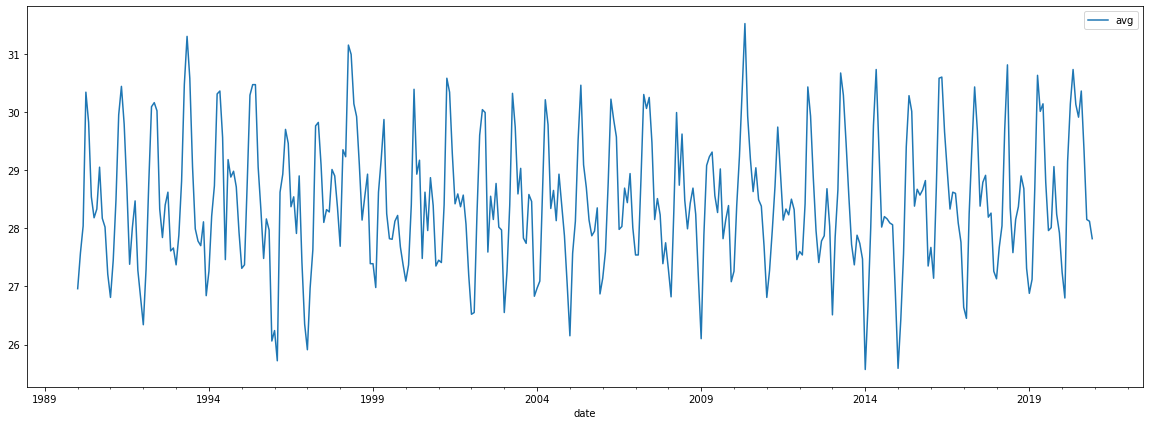

In [9]:
df = df_raw.copy()
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)
df.plot()
plt.autoscale()

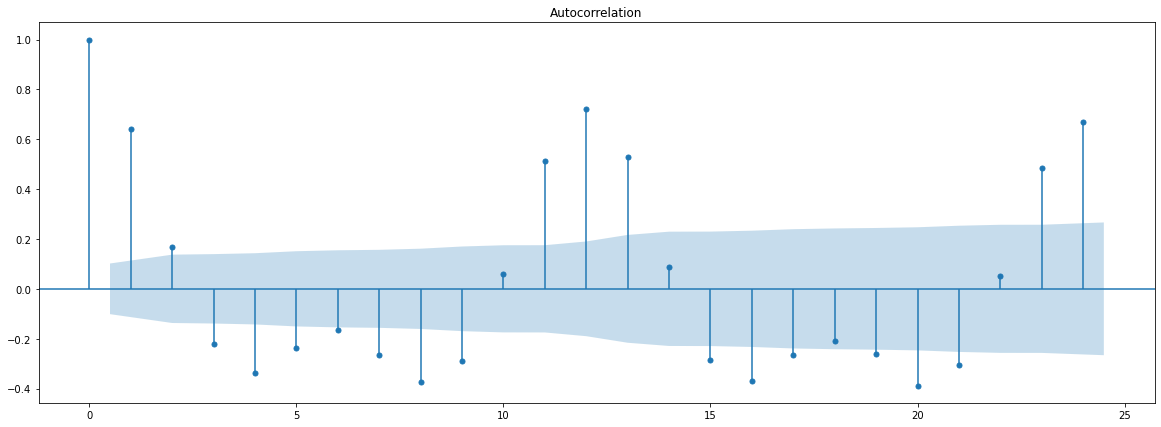

In [81]:
plot_acf(df, lags=12*2)
plt.show()

## Hold out all the observations in 2020. These will be used for the test sets below.

In [18]:
ts_train = df[df.index.year!=2020]
ts_holdout = df[df.index.year==2020]
ts_holdout

,avg
date,
2020-01-01,27.24
2020-02-01,26.80
2020-03-01,29.15
2020-04-01,30.14
2020-05-01,30.73
2020-06-01,30.13
2020-07-01,29.91
2020-08-01,30.36
2020-09-01,29.34


# Pipeline
Implement a pipeline that finds the optimal ARIMA parameters  (𝑝,𝑑,𝑞)  using the training set. [10 pts]

**Predict 6-month ahead**

In [17]:
adf_test(df)

ADF = -5.487622
p-value = 0.000002
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [21]:
h = 6
tskfold = TimeSeriesSplit(n_splits=5, test_size=h)
for train_index, val_index in tskfold.split(ts_train):
    print("Val Index:", val_index, end="--")
    print("Train length: ", len(train_index))

Val Index: [330 331 332 333 334 335]--Train length:  330
Val Index: [336 337 338 339 340 341]--Train length:  336
Val Index: [342 343 344 345 346 347]--Train length:  342
Val Index: [348 349 350 351 352 353]--Train length:  348
Val Index: [354 355 356 357 358 359]--Train length:  354


## ARIMA

### MAE

In [109]:
def cv_arima(ts_train, p,d,q, metric, root=False):
    p_grid = range(p)
    d_grid = range(d)
    q_grid = range(q)
    pdq_grid = list(itertools.product(p_grid, d_grid, q_grid))

    df_results = pd.DataFrame()
    df_results['(p,d,q)'] = pdq_grid
    avg_mae = []

    for pdq in pdq_grid:
        print(pdq) # swap this out for tqdm
        mae = []
        for train_index, val_index in tskfold.split(ts_train):

            # train-val split
            x_train = ts_train.iloc[train_index]
            y_val = ts_train.iloc[val_index]

            x_d = x_train

            # fit ARIMA
            model = ARIMA(x_d, order=pdq).fit()

            # forecast
            y_pred = model.forecast(h)

            # reverse log, s.diff
            # y_pred = x_train[-m:].to_numpy() + y_pred.to_numpy()

            # compile error
            if root:
                mae.append(np.sqrt(metric(y_val, y_pred)))
            
            if not root:
                mae.append(metric(y_val, y_pred))


        # avg error
        avg_mae.append(np.mean(mae))

    df_results[f'Avg. {metric}'] = avg_mae
    return df_results.sort_values(by= f'Avg. {metric}')

In [112]:
cv_arima(ts_train, 12,1,12, mean_absolute_error)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
(0, 0, 5)
(0, 0, 6)
(0, 0, 7)
(0, 0, 8)
(0, 0, 9)
(0, 0, 10)
(0, 0, 11)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 0, 7)
(1, 0, 8)
(1, 0, 9)
(1, 0, 10)
(1, 0, 11)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)


KeyboardInterrupt: 

#### Optimal ARIMA

params = 3,0,3

In [141]:
def test_optimal_arima(ts_train, ts_holdout, p,d,q, metric, horizon, root=False):
    model = ARIMA(ts_train, order=(p,d,q)).fit()
    y_pred = model.forecast(horizon)
    # y_pred = ts_train[-m:].to_numpy() + y_pred.to_numpy()

    df_f = pd.DataFrame()
    df_f['Actual'] = ts_holdout
    df_f['Forecast'] = y_pred
    if horizon == h:
        if root:
            output = np.sqrt(metric( df_f.iloc[:h]['Actual'],  df_f.iloc[:h]['Forecast']))
        if not root:
            output = metric( df_f.iloc[:h]['Actual'],  df_f.iloc[:h]['Forecast'])
        fig, ax = plt.subplots()
        ts_holdout.plot(ax = ax)
        df_f.iloc[:h]['Forecast'].plot(ax=ax)
        plt.show()
        return output
    
    elif horizon == h+h:
        if root:
            output = np.sqrt(metric( df_f.iloc[h:]['Actual'],  df_f.iloc[h:]['Forecast']))
        if not root:
            output = metric( df_f.iloc[h:]['Actual'],  df_f.iloc[h:]['Forecast'])
        fig, ax = plt.subplots()
        ts_holdout.plot(ax = ax)
        df_f.iloc[h:]['Forecast'].plot(ax=ax)
        plt.show()
        return output

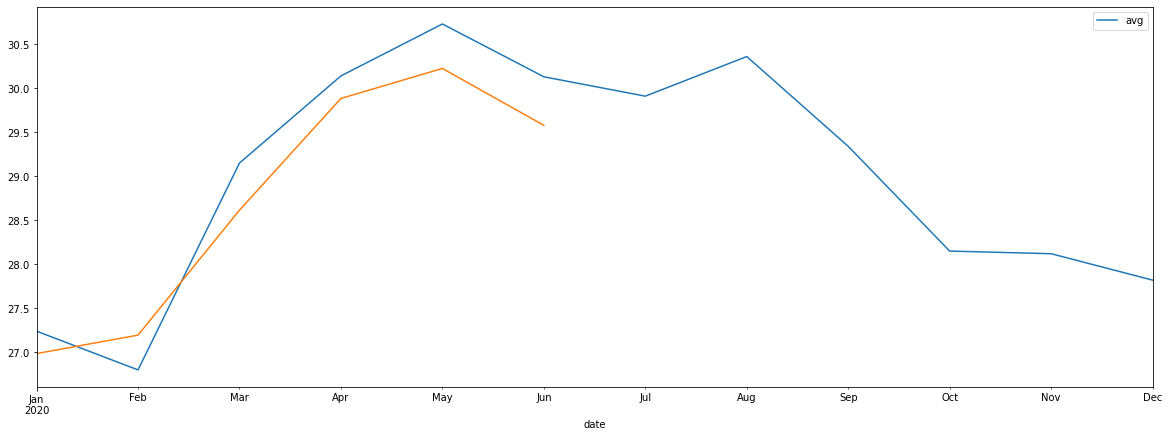

0.4162724044282064

In [142]:
test_optimal_arima(ts_train, ts_holdout, 15,0,12, mean_absolute_error, horizon=h)

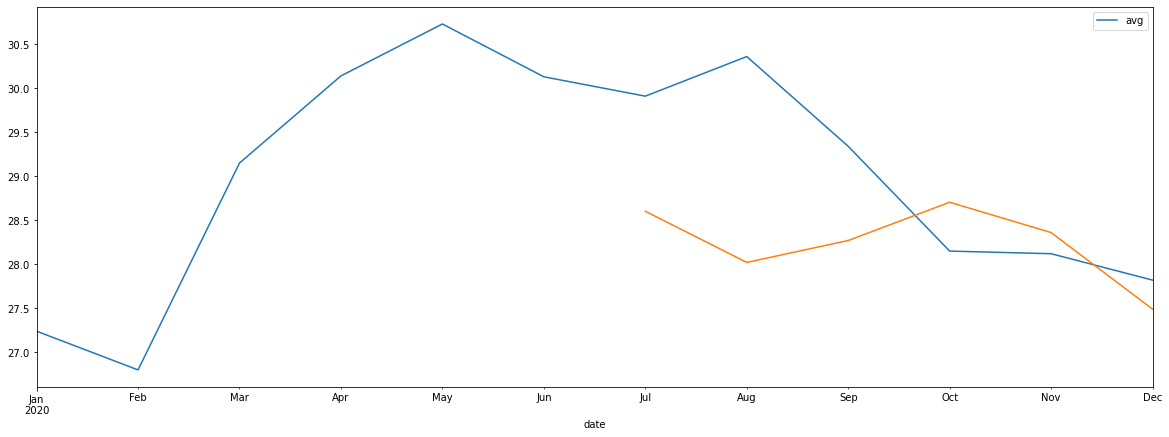

0.9734528560731656

In [143]:
test_optimal_arima(ts_train, ts_holdout, 15,0,12, mean_absolute_error, horizon=h+h)

In [ ]:
0.4162724044282064, 0.6451917578737397, 0.014281359382101066

### RMSE

In [40]:
cv_arima(ts_train, 4,2,4, mean_squared_error, root=True)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 0, 3)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


,"(p,d,q)",Avg. <function mean_squared_error at 0x0000018F5170F790>
27,"(3, 0, 3)",0.794080
16,"(2, 0, 0)",0.825447
21,"(2, 1, 1)",0.825527
17,"(2, 0, 1)",0.840977
1,"(0, 0, 1)",0.841176
19,"(2, 0, 3)",0.841350
26,"(3, 0, 2)",0.843515
2,"(0, 0, 2)",0.844679
7,"(0, 1, 3)",0.844751
10,"(1, 0, 2)",0.865242


#### Optimal ARIMA

In [130]:
test_optimal_arima(ts_train, ts_holdout, 15,0,12, mean_absolute_error, root=True)

0.6451917578737397

### MAPE

In [44]:
cv_arima(ts_train, 4,2,4, mean_absolute_percentage_error)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 0, 3)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


,"(p,d,q)",Avg. <function mean_absolute_percentage_error at 0x0000018F5170F700>
27,"(3, 0, 3)",0.022027
16,"(2, 0, 0)",0.022872
21,"(2, 1, 1)",0.022878
26,"(3, 0, 2)",0.023711
7,"(0, 1, 3)",0.023725
2,"(0, 0, 2)",0.023730
19,"(2, 0, 3)",0.023929
10,"(1, 0, 2)",0.024276
15,"(1, 1, 3)",0.024296
25,"(3, 0, 1)",0.024298


#### Optimal ARIMA

In [131]:
test_optimal_arima(ts_train, ts_holdout, 15,0,12, mean_absolute_percentage_error)

0.014281359382101066

## Naive / Persistence
Todays conditions is tomorrow's forecast

In [57]:
df

,avg
date,
1990-01-01,26.96
1990-02-01,27.57
1990-03-01,28.04
1990-04-01,30.34
1990-05-01,29.82
...,...
2020-08-01,30.36
2020-09-01,29.34
2020-10-01,28.15


In [75]:
# import datetime
df_naive = pd.DataFrame()
df_naive['actual'] = ts_holdout.iloc[:h]
df_naive['forecast'] = df.iloc[-13:-h-1].to_numpy()
df_naive

,actual,forecast
date,,
2020-01-01,27.24,27.92
2020-02-01,26.80,27.24
2020-03-01,29.15,26.80
2020-04-01,30.14,29.15
2020-05-01,30.73,30.14
2020-06-01,30.13,30.73


### MAE

In [77]:
def calculate_metric(df, metric, root=False):
    if root:
        return np.sqrt(metric(df['actual'], df['forecast']))
    else:
        return metric(df['actual'], df['forecast'])

In [78]:
calculate_metric(df_naive, mean_absolute_error)

0.941666666666667

### RMSE

In [79]:
calculate_metric(df_naive, mean_squared_error, root=True)

1.1450400284123985

### MAPE

In [80]:
calculate_metric(df_naive, mean_absolute_percentage_error)

0.032326432895531734

## S. Naive

12 month seasonality

In [86]:
# import datetime
df_snaive = pd.DataFrame()
df_snaive['actual'] = ts_holdout.iloc[:h]
df_snaive['forecast'] = df[df.index.year==2019].iloc[:h].to_numpy()
df_snaive

,actual,forecast
date,,
2020-01-01,27.24,26.88
2020-02-01,26.80,27.12
2020-03-01,29.15,28.69
2020-04-01,30.14,30.63
2020-05-01,30.73,30.01
2020-06-01,30.13,30.14


### MAE

In [88]:
calculate_metric(df_snaive, mean_absolute_error)

0.39333333333333265

### RMSE

In [89]:
calculate_metric(df_snaive, mean_squared_error, root=True)

0.44762335357604577

### MAPE

In [90]:
calculate_metric(df_snaive, mean_absolute_percentage_error)

0.013492639479888095

In [133]:
model = ARIMA(ts_train, order=(15,0,12)).fit()
y_pred = model.forecast(h)
y_pred

2020-01-01    26.985487
2020-02-01    27.195253
2020-03-01    28.614911
2020-04-01    29.884071
2020-05-01    30.224563
2020-06-01    29.578588
Freq: MS, Name: predicted_mean, dtype: float64

# Plotting ALL

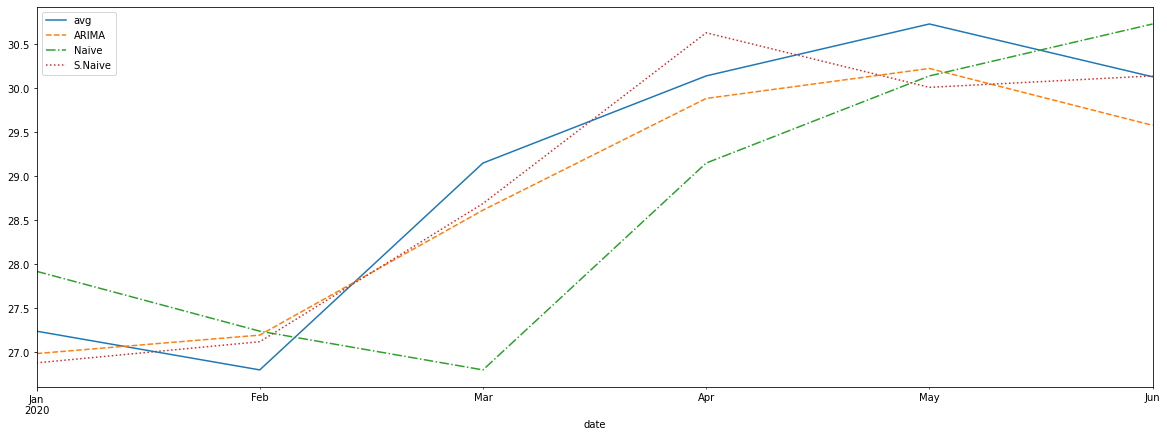

In [134]:
fig, ax = plt.subplots()
ts_holdout.iloc[:h].plot(ax=ax)
y_pred.plot(ax=ax, label='ARIMA', ls='--')
df_naive['forecast'].plot(ax=ax, label='Naive', ls='-.')
df_snaive['forecast'].plot(ax=ax, label='S.Naive', ls='dotted')
plt.legend()

| Forecasting Method | Avg. Test MAE | Avg. Test RMSE | Avg. Test MAPE |
| :---: | :---: | :---: | :---: |
| Naive / Persistence* | 0.941666666666667 | 0.44762335357604577 | 0.013492639479888095 |
| Seasonal Naive | 0.39333333333333265 | 0.44762335357604577 | 0.013492639479888095 |
| ARIMA(3,0,3) | 0.4162724044282064 | 0.6451917578737397 | 0.014281359382101066 |